In [1]:
%load_ext watermark
%watermark -p torch,lightning,torchvision

torch      : 2.7.0+cu128
lightning  : 2.5.2
torchvision: 0.22.0+cu128



In [2]:
import lightning as L
import torch
import torchvision
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np

from shared_utilities import LightningModel,Cifar10DataModule,plot_loss_and_acc

In [3]:
L.pytorch.seed_everything(123)

dm = Cifar10DataModule(batch_size=64)
dm.prepare_data()
dm.setup()

Seed set to 123


In [4]:
len(dm.train), len(dm.valid), len(dm.test)

(45000, 5000, 10000)

In [5]:
for images, labels in dm.train_dataloader():
    break


In [6]:
from collections import Counter

train_counter = Counter()
for images, labels in dm.train_dataloader():
    train_counter.update(labels.tolist())

print(f"Training labels dist")
print(sorted(train_counter.items()))

test_counter = Counter()
for images, labels in dm.test_dataloader():
    test_counter.update(labels.tolist())

print(f"testing labels dist")
print(sorted(test_counter.items()))

Training labels dist
[(0, 4511), (1, 4469), (2, 4502), (3, 4503), (4, 4510), (5, 4450), (6, 4517), (7, 4504), (8, 4506), (9, 4520)]
testing labels dist
[(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


In [7]:
sum(test_counter.values())

10000

In [8]:
# majority class

majority_class = test_counter.most_common(1)[0]
print(f"Majority class ", majority_class)

baseline_acc = majority_class[1]/sum(test_counter.values())
print(f"Baseline Accuracy when we predict the most common all the time :")
print(f"{baseline_acc:.3f} {baseline_acc*100:.3f}%")

Majority class  (3, 1000)
Baseline Accuracy when we predict the most common all the time :
0.100 10.000%


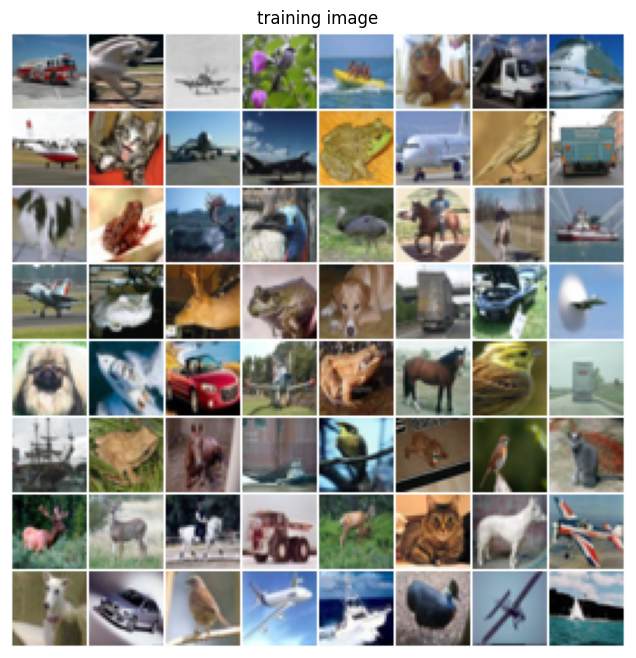

In [9]:
for images, labels in dm.train_dataloader():
    break

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title("training image")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            images[:64],
            padding=1,
            pad_value=1.0,
            normalize=True
        ),
        (1,2,0)
    )
)
plt.show()

In [ ]:
import torch

entrypoints = torch.hub.list('pytorch/vision',force_reload=True)
for e in entrypoints:
    if "resnet" in e:
        print(e)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /home/zeus/.cache/torch/hub/main.zip
deeplabv3_resnet101
deeplabv3_resnet50
fcn_resnet101
fcn_resnet50
resnet101
resnet152
resnet18
resnet34
resnet50
wide_resnet101_2
wide_resnet50_2


In [13]:


%%capture --no-display

L.pytorch.seed_everything(123)
repo = "pytorch/vision"

dm = Cifar10DataModule(height_width=(128,128), num_workers=4)
pytorch_model = torch.hub.load(repo, "resnet18", weights=None)
l_model = LightningModel(model=pytorch_model, learning_rate=0.1, num_classes=10)

trainer= L.Trainer(
    # fast_dev_run=1,
    max_epochs=30,
    accelerator='auto',
    devices=1,
    logger=CSVLogger(save_dir='logs/', name='cifr-resnet18'),
    deterministic=True
)

Seed set to 123
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(model=l_model, datamodule=dm)


  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.7 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.758    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

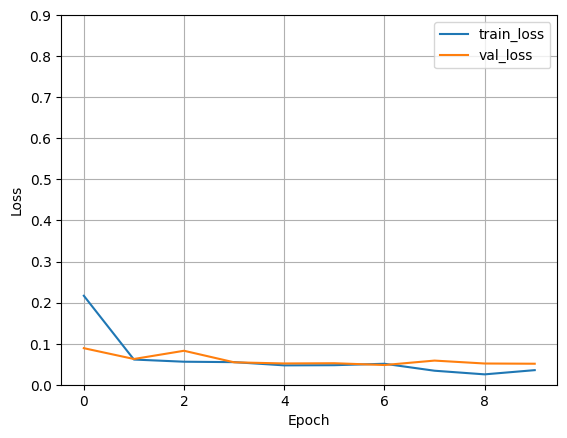

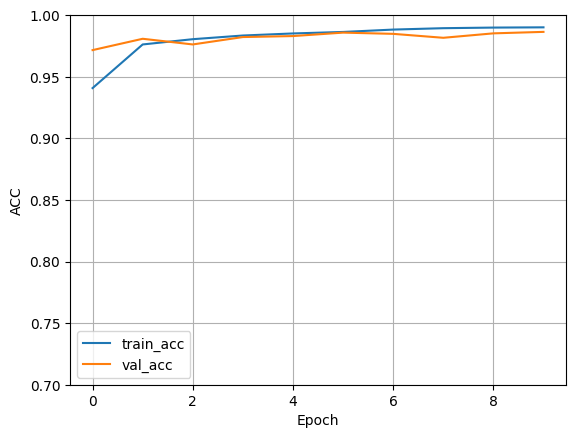

In [19]:
plot_loss_and_acc(trainer.logger.log_dir)

In [20]:
trainer.test(model=l_model, datamodule=dm)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9860000014305115     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9860000014305115}]